# Gluon Model Evaluation Using `SigmoidBinaryCrossEntropyLoss`

In [1]:
# Import necessary Libraries
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon
import numpy as np
import h5py
from sklearn.metrics import accuracy_score

/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


### Datasets

In [2]:
# Import the Datasets
dataset = h5py.File('datasets/datasets.h5', 'r')
train_set_x_orig = np.array(dataset['train_set_x'][:])
train_set_y_orig = np.array(dataset['train_set_y'][:])
test_set_x_orig = np.array(dataset['test_set_x'][:])
test_set_y_orig = np.array(dataset['test_set_y'][:])

In [3]:
# View Training Dataset
print("Training Data Dimensions: {}".format(train_set_x_orig.shape))
print("No. Examples: {}".format(train_set_x_orig.reshape((-1, 12288)).shape[0]))
print("No. Inputs: {}".format(train_set_x_orig.reshape((-1, 12288)).shape[1]))

Training Data Dimensions: (209, 64, 64, 3)
No. Examples: 209
No. Inputs: 12288


In [4]:
# View Testing Dataset
print("Testing Data Dimensions: {}".format(test_set_x_orig.shape))
print("No. Examples: {}".format(test_set_x_orig.reshape((-1, 12288)).shape[0]))
print("No. Inputs: {}".format(test_set_x_orig.reshape((-1, 12288)).shape[1]))

Testing Data Dimensions: (50, 64, 64, 3)
No. Examples: 50
No. Inputs: 12288


In [5]:
# Pre-process Data
def transform(x):
    v = x.reshape((x.shape[0], (x.shape[1] * x.shape[2]) * x.shape[3]))
    return v.astype(np.float32) / 255
train_data = transform(train_set_x_orig)
train_label = train_set_y_orig.astype(np.float32)
test_data = transform(test_set_x_orig)
test_label = test_set_y_orig.astype(np.float32)
print("Final Training Data Dimensions: {}".format(train_data.shape))
print("Final Testing Data Dimensions: {}".format(test_data.shape))

Final Training Data Dimensions: (209, 12288)
Final Testing Data Dimensions: (50, 12288)


### Neural Network Configuration

In [6]:
# Configure the Dataset
batch_size = 64 # Using full set of observations
num_examples = 209
net_dims = [20, 7, 5, 1]
lr = 0.0075

# Create Training and Test Data Iterator
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(
        train_data,
        train_label
    ),
    shuffle=True,
    batch_size=batch_size
)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(
        test_data,
        test_label
    ),
    shuffle=False,
    batch_size=batch_size
)

### Neural Network Model

In [7]:
# Network Model
model_ctx = mx.cpu()
net = gluon.nn.HybridSequential()
with net.name_scope():
    net.add(gluon.nn.Dense(net_dims[0], activation='relu'))
    net.add(gluon.nn.Dense(net_dims[1], activation='relu'))
    net.add(gluon.nn.Dense(net_dims[2], activation='relu'))
    net.add(gluon.nn.Dense(net_dims[3], activation='sigmoid'))
net.hybridize()

# Parameter Initialization
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24))
# Optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
# Cross Entropy Loss Function
binary_ce = gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)

# Evlauation metric
def eval_acc(data_iterator, net):
    acc = mx.metric.Accuracy()
    acc.reset()
    for i, (data, label) in enumerate(data_iterator):
        #acc.reset()
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        output = net(data)
        #predictions = nd.argmax(output, axis=1)
        predictions = (nd.sign(output) + 1) / 2
        #num_correct = nd.sum(predictions == label)
        acc.update(preds=output, labels=label)
    return acc.get()[1]
    #return num_correct.asscalar()/209

In [8]:
# Scikit Accuracy Score
def accuracy(data_iterator, net, Y):
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        output = net(data)
        decision_boundary = np.vectorize(lambda x: 1 if x > 0.5 else 0)
        y_pred = list(decision_boundary(output.asnumpy()).flat)
        Y = list(Y.flat)
        
    return accuracy_score(Y, y_pred)

### Model Training

In [9]:
# Training Loop
epochs = 2500
costs = []

for e in range(epochs):
    cumulative_loss = 0
    # Enumerate bacthes
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        # Record for calculating derivatives for forward pass
        with autograd.record():
            output = net(data)
            loss = binary_ce(output, label)
        # Run backward pass
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()
    test_accuracy = accuracy(test_data, net, test_set_y_orig)
    #train_accuracy = accuracy(train_data, net, train_set_y_orig)
    costs.append(cumulative_loss/num_examples)
    if e % 100 ==0:
        #print("Epoch: {}; Loss: {}; Training Acc: {}; Testing Acc: {}"\
        #      .format(e,cumulative_loss/num_examples,train_accuracy,test_accuracy))
        print("Epoch: {}; Loss: {}; Test Set Accuracy: {}"\
              .format(e,cumulative_loss/num_examples,test_accuracy))

Epoch: 0; Loss: 0.709189761769; Test Set Accuracy: 0.46
Epoch: 100; Loss: 0.53746396845; Test Set Accuracy: 0.58
Epoch: 200; Loss: 0.337173338712; Test Set Accuracy: 0.66
Epoch: 300; Loss: 0.207889552322; Test Set Accuracy: 0.76
Epoch: 400; Loss: 0.149772625791; Test Set Accuracy: 0.76
Epoch: 500; Loss: 0.123271500665; Test Set Accuracy: 0.76
Epoch: 600; Loss: 0.103323252007; Test Set Accuracy: 0.76
Epoch: 700; Loss: 0.0916125175485; Test Set Accuracy: 0.76
Epoch: 800; Loss: 0.083623699024; Test Set Accuracy: 0.76
Epoch: 900; Loss: 0.0776904071347; Test Set Accuracy: 0.76
Epoch: 1000; Loss: 0.0730928636054; Test Set Accuracy: 0.76
Epoch: 1100; Loss: 0.0695642429676; Test Set Accuracy: 0.76
Epoch: 1200; Loss: 0.0670987915194; Test Set Accuracy: 0.76
Epoch: 1300; Loss: 0.0645071664495; Test Set Accuracy: 0.76
Epoch: 1400; Loss: 0.0626304982382; Test Set Accuracy: 0.76
Epoch: 1500; Loss: 0.0612086715025; Test Set Accuracy: 0.76
Epoch: 1600; Loss: 0.0599211234795; Test Set Accuracy: 0.76
E

### Training Analysis

Epoch: 2499
Loss: 0.0539063336461
Test Set Accuracy: 76.0%


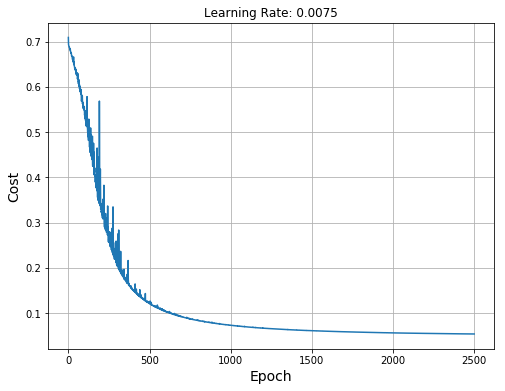

In [10]:
# Final Score
final_accuracy = accuracy(test_data, net, test_set_y_orig)
print("Epoch: {}\nLoss: {}\nTest Set Accuracy: {}%".format(e,cumulative_loss/num_examples, final_accuracy*100))

# Plot the convergence of the cost function
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure(num=None,figsize=(8, 6))
plt.plot(costs)
plt.grid(True, which="both")
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Cost',fontsize=14)
plt.title("Learning Rate: " + str(lr))
plt.show;

### Predict on Unseen Data

In [11]:
# Predict Funciton
def predict(image, nn):
    data = nd.array(image).as_in_context(model_ctx)
    output = nn(data)
    prediction = (nd.sign(output) + 1) /2
    return prediction

#### Grumpy Cat

In [12]:
# Display and predict against grumpy cat image
from skimage import transform
classes = ['non-cat', 'cat']
my_image = "grumpy_cat.jpeg"
#y = [1] # the true class label of the image (1 -> cat)
fname = "images/" + my_image
# Read the image
img = plt.imread(fname)
# Pre-process the image
image = transform.resize(img, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
# Run the model against the image
my_predicted_image = np.squeeze(predict(image, net).asnumpy()[0])
# Plot the final image
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.imshow(img);
# Print the results
print ("y = " + str(np.squeeze(my_predicted_image)) + \
       "\nThe trained model predicts a \"" + \
       classes[int(my_predicted_image)] +  "\" picture.")

IOError: [Errno 2] No such file or directory: 'images/grumpy_cat.jpeg'

#### Gargouille

In [ ]:
# Display and predict against the gargouille image
my_image = "gargouille.jpeg"
#y = [1] # the true class label of the image (1 -> cat)
fname = "images/" + my_image
# Read the image
img = plt.imread(fname)
# Pre-process the image
image = transform.resize(img, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
# Run the model against the image
my_predicted_image = np.squeeze(predict(image, net).asnumpy()[0])
# Plot the final image
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.imshow(img);
# Print the results
print ("y = " + str(np.squeeze(my_predicted_image)) + \
       "\nThe trained model predicts a \"" + \
       classes[int()] +  "\" picture.")

### Save the Model and Optmized Parameters

In [ ]:
# Create aplaceholder
z = net(mx.sym.var('data'))

# Save the model
z.save('model.json')

# Save the Optimized Parameters
net.collect_params().save('model.params')

### Load the Model and Test

In [ ]:
symbol = mx.sym.load('model.json')
outputs = mx.sym.sigmoid(data=symbol, name='sigmoid_label')
inputs = mx.sym.var('data')
param_dict = gluon.ParameterDict('model_')
model = gluon.SymbolBlock(outputs, inputs, param_dict)
model.load_params('model.params', ctx=model_ctx)

In [ ]:
# Display and predict against grumpy cat image
from skimage import transform
classes = ['non-cat', 'cat']
my_image = "grumpy_cat.jpeg"
#y = [1] # the true class label of the image (1 -> cat)
fname = "images/" + my_image
# Read the image
img = plt.imread(fname)
# Pre-process the image
image = transform.resize(img, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
# Run the model against the image
my_predicted_image = np.squeeze(predict(image, model).asnumpy()[0])
# Plot the final image
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.imshow(img);
# Print the results
print ("y = " + str(np.squeeze(my_predicted_image)) + \
       "\nThe trained model predicts a \"" + \
       classes[int(my_predicted_image)] +  "\" picture.")

In [ ]:
# Display and predict against the gargouille image
my_image = "gargouille.jpeg"
#y = [1] # the true class label of the image (1 -> cat)
fname = "images/" + my_image
# Read the image
img = plt.imread(fname)
# Pre-process the image
image = transform.resize(img, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
# Run the model against the image
my_predicted_image = np.squeeze(predict(image, model).asnumpy()[0])
# Plot the final image
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.imshow(img);
# Print the results
print ("y = " + str(np.squeeze(my_predicted_image)) + \
       "\nThe trained model predicts a \"" + \
       classes[int()] +  "\" picture.")